In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

c:\users\knock\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  del sys.path[0]


In [2]:
#importing dataset
data = np.loadtxt(open(r'C:\Users\knock\Downloads\mnist_train_small.csv','rb'),delimiter=",")

In [3]:
#extract labels(number ids) and remove from data
labels = data[:,0]
data = data[:,1:]

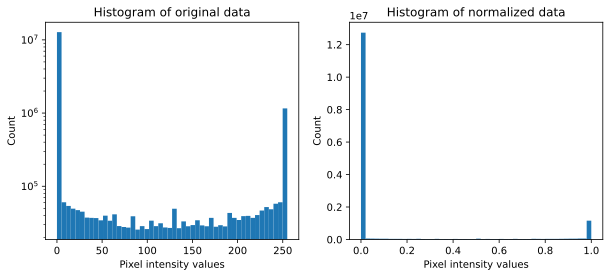

In [4]:
#normalize the data to range of [0 1]
data_norm = data/np.max(data)

fig,ax = plt.subplots(1,2,figsize = (10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel("Count")
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(data_norm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

In [9]:
#step 1: convert to tensor
data = torch.tensor(data_norm).float()
label = torch.tensor(labels).long()
data = np.array(data)
label = np.array(label)
#step 2: use scikit learn to split data
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1, random_state=42)
X_train=torch.tensor(X_train).float()
X_test=torch.tensor(X_test).float()
y_train=torch.tensor(y_train).long()
y_test=torch.tensor(y_test).long()

#step 3: convert into pytorch Dataset
train_data = TensorDataset(X_train,y_train)
test_data = TensorDataset(X_test,y_test)

#step: 4 Translate into dataloader object
batch_size = 32
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [11]:
#check all variable types in the workspace
%whos

Variable                        Type             Data/Info
----------------------------------------------------------
DataFrame                       type             <class 'pandas.core.frame.DataFrame'>
DataLoader                      type             <class 'torch.utils.data.dataloader.DataLoader'>
F                               module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
MultiIndex                      type             <class 'pandas.core.indexes.multi.MultiIndex'>
TensorDataset                   type             <class 'torch.utils.data.dataset.TensorDataset'>
X_test                          Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
X_train                         Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
ax                              ndarray          2: 2 elems, type `object`, 16 bytes
batch_size                      int              32
data                            ndarray          20

In [14]:
#Create a class for the model
def class_mnist():

    class mnist_clf(nn.Module):
        def __init__(self):
            super().__init__()

            #input layer
            self.input = nn.Linear(784,64)

            ##hidden layer
            self.h1 = nn.Linear(64,32)
            self.h2 = nn.Linear(32,32)

            ## Output layer
            self.output = nn.Linear(32,10)

        #forward pass
        def forward(self,x):

            x = F.relu( self.input(x) )
            x = F.relu( self.h1(x) )
            x = F.relu( self.h2(x) )
            return torch.log_softmax( self.output(x), axis=1 )
        #NEW HERE: log_softmax the ouput, because I'am using NLLLoss instead opf Cross entropy loss

    #create teh model instance
    net_clf = mnist_clf()

    #loss fuinction
    loss_fun = nn.NLLLoss()

    #optimizer
    optimizer = torch.optim.Adam(net_clf.parameters(),lr = .01)

    return net_clf,loss_fun,optimizer

In [15]:
#test the model with one batch

net_clf, loss_fun, optimizer = class_mnist()

X,y = iter(train_loader).next()
y_hat = net_clf(X)

#values are log-probability of each number (0-9)
print(y_hat)

#now let's compute the loss
loss = loss_fun(y_hat,y)
print(' ')
print('Loss: ')
print(loss)

tensor([[-2.4152, -2.3895, -2.2534, -2.3875, -2.4476, -2.4823, -2.0442, -2.3020,
         -2.2290, -2.1641],
        [-2.4084, -2.4015, -2.2331, -2.3657, -2.4789, -2.4698, -2.0484, -2.3022,
         -2.2319, -2.1747],
        [-2.4047, -2.3805, -2.2577, -2.3791, -2.4602, -2.4880, -2.0433, -2.3042,
         -2.2231, -2.1734],
        [-2.4143, -2.3893, -2.2573, -2.3833, -2.4540, -2.4835, -2.0463, -2.2997,
         -2.2244, -2.1632],
        [-2.4011, -2.4000, -2.2494, -2.3731, -2.4695, -2.4801, -2.0420, -2.3201,
         -2.2219, -2.1611],
        [-2.4143, -2.3952, -2.2479, -2.3814, -2.4566, -2.4710, -2.0495, -2.3141,
         -2.2230, -2.1609],
        [-2.4033, -2.3920, -2.2458, -2.3669, -2.4733, -2.4749, -2.0423, -2.3140,
         -2.2266, -2.1754],
        [-2.4242, -2.3924, -2.2434, -2.3756, -2.4591, -2.4686, -2.0582, -2.2970,
         -2.2202, -2.1721],
        [-2.4202, -2.3879, -2.2417, -2.3733, -2.4532, -2.4713, -2.0552, -2.3044,
         -2.2328, -2.1697],
        [-2.4137, -

### Create a function that trains the model

In [18]:
def train_model():

    #number of epochs
    num_epochs = 100

    #create a new model
    net_clf,loss_fun,optimizer = class_mnist()

    #initialize losses
    losses = torch.zeros(num_epochs)
    train_acc = []
    test_acc = []

    #loop over epochs
    for epochi in range(num_epochs):

        batch_acc = []
        batch_loss = []

        #loop over batches
        for X,y in train_loader:

            #forward pass and loss
            y_hat = net_clf(X)
            loss = loss_fun(y_hat,y)

            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #loss from this batch
            batch_loss.append(loss.item())

            #compute accuracy
            matches = torch.argmax(y_hat,axis=1) == y           #booleans (false/true)
            matches_numeric = matches.float()                   #Convert to numbers (0/1)
            accuracy = 100*torch.mean(matches_numeric)          #average and x100
            batch_acc.append(accuracy)                          #add to list of accuracies
        #end of batch loop......

        #now that we have trained through the bathces, get their average training accuracy
        train_acc.append( np.mean(batch_acc) )

        # and get average losses over the batches
        losses[epochi] = np.mean(batch_loss)

        #test accuracy
        X,y = next(iter(test_loader)) # extract X,y from teh test_loader

        y_hat = net_clf(X)

        #test accuracy
        test_acc.append( 100*torch.mean((torch.argmax(y_hat,axis=1)==y).float()) )
    #end of loops
    return train_acc,test_acc,losses,net_clf

### Run the model and show the test

In [19]:
train_acc,test_acc,losses,net_clf  =  train_model()

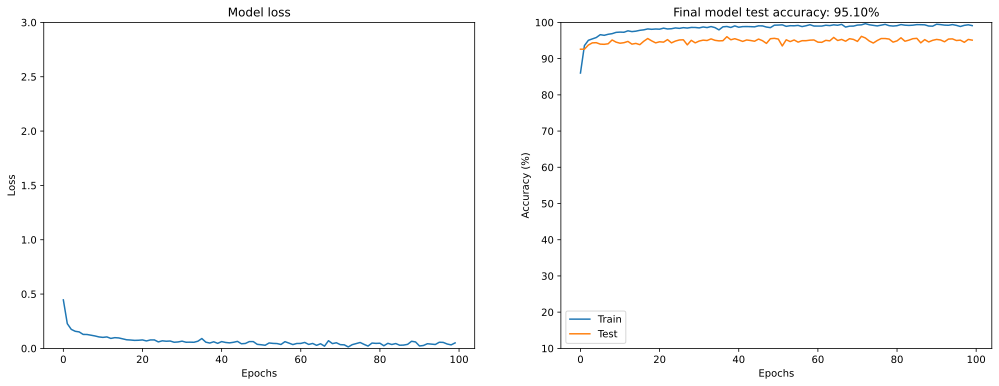

In [21]:
fig, ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc,label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

### Inspect the model in more details

In [26]:
#Run the model through for the test data
X,y = next(iter(test_loader))
prediction = net_clf(X).detach()

torch.exp(prediction) #from log probavilities to actual probabilities

tensor([[0.0000e+00, 2.9590e-28, 0.0000e+00,  ..., 6.0030e-17, 3.8444e-18,
         1.0000e+00],
        [0.0000e+00, 1.5276e-28, 0.0000e+00,  ..., 1.9473e-37, 0.0000e+00,
         1.5288e-42],
        [1.9559e-15, 1.3384e-22, 1.0000e+00,  ..., 7.5943e-13, 1.3203e-18,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 1.4925e-38,  ..., 4.5833e-35, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.0000e+00, 7.5813e-33,  ..., 1.3899e-31, 1.6957e-10,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.6842e-43, 1.9552e-35,
         1.5414e-44]])

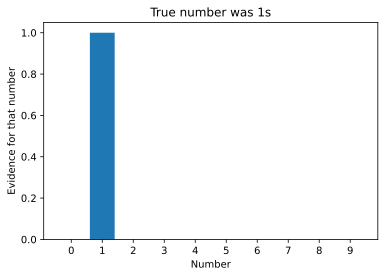

In [31]:
#Evidence for all numbers from one sample

sample_show = 120

plt.bar(range(10), torch.exp(prediction[sample_show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %ds' %y[sample_show].item())
plt.show()

In [32]:
#find the errors
errors = np.where( torch.max(prediction, axis=1)[1] != y)[0]
print(errors)

[  22   24   35   49   79   99  124  152  191  192  198  211  240  241
  335  350  389  394  397  419  431  435  443  492  494  565  571  588
  614  622  640  641  666  691  714  723  743  748  790  830  834  835
  837  871  880  884  886  911  933  940  941  970  988  996 1024 1032
 1049 1087 1088 1149 1205 1211 1213 1226 1232 1259 1274 1288 1297 1324
 1339 1390 1397 1403 1438 1445 1461 1467 1476 1511 1562 1564 1602 1652
 1683 1694 1728 1740 1757 1769 1770 1808 1814 1891 1941 1956 1961 1981]


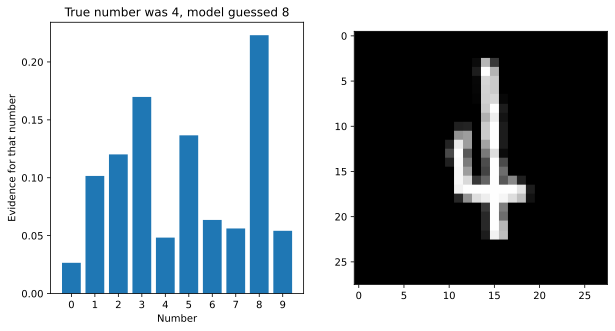

In [41]:
# Evidence for all number from one  sample
sample_show = 10

fig, ax = plt.subplots(1,2,figsize=(10,5))


ax[0].bar(range(10), torch.exp(prediction[errors[sample_show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number was %s, model guessed %s' %( y[errors[sample_show]].item(),torch.argmax(prediction[errors[sample_show]]).item()) )

ax[1].imshow( np.reshape(X[errors[sample_show],:],(28,28)), cmap='gray')


plt.show()

### Thanks for checking